# Loan Defaulter Prediction

In [ ]:
!pip install -q hvplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 11.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/loan-data/loan-data.csv')
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.00,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.00,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.00,0.00,36369.00,41.80,25.00,w,INDIVIDUAL,0.00,0.00,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.00,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.00,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.00,0.00,20131.00,53.30,27.00,f,INDIVIDUAL,3.00,0.00,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.00,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.00,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.00,0.00,11987.00,92.20,26.00,f,INDIVIDUAL,0.00,0.00,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.00,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.00,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.00,0.00,5472.00,21.50,13.00,f,INDIVIDUAL,0.00,0.00,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.00,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.00,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.00,0.00,24584.00,69.80,43.00,f,INDIVIDUAL,1.00,0.00,"679 Luna Roads\r\nGreggshire, VA 11650"


In [ ]:
data.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,396030.00,395754.00,396030.00,358235.00,395495.00
mean,14113.89,13.64,431.85,74203.18,17.38,11.31,0.18,15844.54,53.79,25.41,1.81,0.12
std,8357.44,4.47,250.73,61637.62,18.02,5.14,0.53,20591.84,24.45,11.89,2.15,0.36
min,500.00,5.32,16.08,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00
25%,8000.00,10.49,250.33,45000.00,11.28,8.00,0.00,6025.00,35.80,17.00,0.00,0.00
50%,12000.00,13.33,375.43,64000.00,16.91,10.00,0.00,11181.00,54.80,24.00,1.00,0.00
75%,20000.00,16.49,567.30,90000.00,22.98,14.00,0.00,19620.00,72.90,32.00,3.00,0.00
max,40000.00,30.99,1533.81,8706582.00,9999.00,90.00,86.00,1743266.00,892.30,151.00,34.00,8.00


# Data PreProcessing

In [ ]:
# The length of the data
print(f"The Length of the data: {data.shape}")

The Length of the data: (396030, 27)


In [ ]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'emp_title': number of missing values '22927' ==> '5.789%'
'emp_length': number of missing values '18301' ==> '4.621%'
'title': number of missing values '1756' ==> '0.443%'
'revol_util': number of missing values '276' ==> '0.070%'
'mort_acc': number of missing values '37795' ==> '9.543%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


### `emp_title`

In [ ]:
data.emp_title.nunique()

173105

Realistically there are too many unique job titles to try to convert this to a dummy variable feature. Let's remove that emp_title column.

In [ ]:
data.drop('emp_title', axis=1, inplace=True)

### `emp_length`

In [ ]:
data.emp_length.unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [ ]:
for year in data.emp_length.unique():
    print(f"{year} years in this position:")
    print(f"{data[data.emp_length == year].loan_status.value_counts(normalize=True)}")
    print('==========================================')

10+ years years in this position:
loan_status
Fully Paid    0.82
Charged Off   0.18
Name: proportion, dtype: float64
4 years years in this position:
loan_status
Fully Paid    0.81
Charged Off   0.19
Name: proportion, dtype: float64
< 1 year years in this position:
loan_status
Fully Paid    0.79
Charged Off   0.21
Name: proportion, dtype: float64
6 years years in this position:
loan_status
Fully Paid    0.81
Charged Off   0.19
Name: proportion, dtype: float64
9 years years in this position:
loan_status
Fully Paid    0.80
Charged Off   0.20
Name: proportion, dtype: float64
2 years years in this position:
loan_status
Fully Paid    0.81
Charged Off   0.19
Name: proportion, dtype: float64
3 years years in this position:
loan_status
Fully Paid    0.80
Charged Off   0.20
Name: proportion, dtype: float64
8 years years in this position:
loan_status
Fully Paid    0.80
Charged Off   0.20
Name: proportion, dtype: float64
7 years years in this position:
loan_status
Fully Paid    0.81
Charged Off   

Charge off rates are extremely similar across all employment lengths. So we are going to drop the `emp_length` column.

In [ ]:
data.drop('emp_length', axis=1, inplace=True)

### `title`

In [ ]:
data.title.value_counts().head()

,count
title,
Debt consolidation,152472
Credit card refinancing,51487
Home improvement,15264
Other,12930
Debt Consolidation,11608


In [ ]:
data.purpose.value_counts().head()

,count
purpose,
debt_consolidation,234507
credit_card,83019
home_improvement,24030
other,21185
major_purchase,8790


The title column is simply a string subcategory/description of the purpose column. So we are going to drop the title column.

In [ ]:
data.drop('title', axis=1, inplace=True)

### `mort_acc`

There are many ways we could deal with this missing data. We could attempt to build a simple model to fill it in, such as a linear model, we could just fill it in based on the mean of the other columns, or you could even bin the columns into categories and then set NaN as its own category. There is no 100% correct approach!

Let's review the other columsn to see which most highly correlates to mort_acc

In [ ]:
data.mort_acc.value_counts()

,count
mort_acc,
0.00,139777
1.00,60416
2.00,49948
3.00,38049
4.00,27887
5.00,18194
6.00,11069
7.00,6052
8.00,3121


In [ ]:
data.mort_acc.isna().sum()

37795

In [ ]:
data.corr(numeric_only=True)['mort_acc'].drop('mort_acc').sort_values().hvplot.barh()

:Bars   [index]   (mort_acc)


Looks like the total_acc feature correlates with the mort_acc , this makes sense! Let's try this fillna() approach. We will group the dataframe by the total_acc and calculate the mean value for the mort_acc per total_acc entry. To get the result below:

In [ ]:
data[['total_acc', 'mort_acc']].dtypes

,0
total_acc,float64
mort_acc,float64


In [ ]:
data['total_acc'] = pd.to_numeric(data['total_acc'], errors='coerce')
data['mort_acc'] = pd.to_numeric(data['mort_acc'], errors='coerce')

In [ ]:
data['total_acc'] = data['total_acc'].fillna(data['total_acc'].mean())
data['mort_acc'] = data['mort_acc'].fillna(data['mort_acc'].mean())

In [ ]:
total_acc_avg = data.groupby('total_acc')['mort_acc'].mean()

In [ ]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [ ]:
data['mort_acc'] = data.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

### `revol_util` & `pub_rec_bankruptcies`
These two features have missing data points, but they account for less than 0.5% of the total data. So we are going to remove the rows that are missing those values in those columns with dropna().

In [ ]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'revol_util': number of missing values '276' ==> '0.070%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


In [ ]:
data.dropna(inplace=True)

In [ ]:
data.shape

(395219, 24)

## Categorical Variables and Dummy Variables

In [ ]:
print([column for column in data.columns if data[column].dtype == object])

['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'earliest_cr_line', 'initial_list_status', 'application_type', 'address']


### `term`

In [ ]:
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [ ]:
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

In [ ]:
data.term.unique()

array([36, 60])

### `grade` & `sub_grade`

We know that `grade` is just a sub feature of `sub_grade`, So we are goinig to drop it.

In [ ]:
data.drop('grade', axis=1, inplace=True)

In [ ]:
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status',
           'application_type', 'home_ownership']
data = pd.get_dummies(data, columns=dummies, drop_first=True)

### `address`
We are going to feature engineer a zip code column from the address in the data set. Create a column called 'zip_code' that extracts the zip code from the address column.

In [ ]:
data.address.head()

,address
0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,"679 Luna Roads\r\nGreggshire, VA 11650"


In [ ]:
data['zip_code'] = data.address.apply(lambda x: x[-5:])

In [ ]:
data.zip_code.value_counts()

,count
zip_code,
70466,56880
22690,56413
30723,56402
48052,55811
00813,45725
29597,45393
05113,45300
11650,11210
93700,11126


In [ ]:
data = pd.get_dummies(data, columns=['zip_code'], drop_first=True)

In [ ]:
data.drop('address', axis=1, inplace=True)

### `issue_d`

This would be data leakage, we wouldn't know beforehand whether or not a loan would be issued when using our model, so in theory we wouldn't have an issue_date, drop this feature.

In [ ]:
data.drop('issue_d', axis=1, inplace=True)

### `earliest_cr_line`
This appears to be a historical time stamp feature. Extract the year from this feature using a `.apply()` function, then convert it to a numeric feature.

In [ ]:
print(data['earliest_cr_line'].dtype)

object


In [ ]:
if data['earliest_cr_line'].dtype != 'datetime64[ns]':
    data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])

<ipython-input-41-550dfe84d950>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])


In [ ]:
data['earliest_cr_line'] = data.earliest_cr_line.dt.year

In [ ]:
data.earliest_cr_line.nunique()

65

In [ ]:
data.earliest_cr_line.value_counts()

,count
earliest_cr_line,
2000,29302
2001,29031
1999,26444
2002,25849
2003,23623
...,...
1951,3
1950,3
1953,2


## Train Test Split

In [ ]:
print(data.drop('loan_status', axis=1).columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1',
       'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5',
       'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4',
       'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3',
       'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2',
       'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1',
       'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5',
       'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4',
       'sub_grade_G5', 'verification_status_Source Verified',
       'verification_status_Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_im

In [ ]:
w_p = data.loan_status.value_counts()[0] / data.shape[0]
w_n = data.loan_status.value_counts()[1] / data.shape[0]

print(f"Weight of positive values {w_p}")
print(f"Weight of negative values {w_n}")

Weight of positive values 0.8038479931379817
Weight of negative values 0.19615200686201828


<ipython-input-47-1791c04af5de>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w_p = data.loan_status.value_counts()[0] / data.shape[0]
<ipython-input-47-1791c04af5de>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  w_n = data.loan_status.value_counts()[1] / data.shape[0]


In [ ]:
train, test = train_test_split(data, test_size=0.33, random_state=42)

print(train.shape)
print(test.shape)

(264796, 81)
(130423, 81)


# Removing Outliers

In [ ]:
print(train[train['dti'] <= 50].shape)
print(train.shape)

(264776, 81)
(264796, 81)


In [ ]:
print(train.shape)
train = train[train['annual_inc'] <= 250000]
train = train[train['dti'] <= 50]
train = train[train['open_acc'] <= 40]
train = train[train['total_acc'] <= 80]
train = train[train['revol_util'] <= 120]
train = train[train['revol_bal'] <= 250000]
print(train.shape)

(264796, 81)
(262143, 81)


## Normalizing the data

In [ ]:
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

In [ ]:
X_train.dtypes

,0
loan_amnt,float64
term,int64
int_rate,float64
installment,float64
annual_inc,float64
...,...
zip_code_30723,bool
zip_code_48052,bool
zip_code_70466,bool
zip_code_86630,bool


In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Building

In [ ]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [ ]:
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = y_train.map({'Fully Paid': 1, 'Charged Off': 0}).astype(np.float32)
y_test = y_test.map({'Fully Paid': 1, 'Charged Off': 0}).astype(np.float32)

# Artificial Neural Networks (ANNs)

In [ ]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='relu')(x)
    x = tf.keras.layers.Activation('sigmoid')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [ ]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns,
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32
)

Epoch 1/5
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - AUC: 0.8310 - loss: 0.3773 - val_AUC: 0.8978 - val_loss: 0.3222
Epoch 2/5
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - AUC: 0.8722 - loss: 0.3453 - val_AUC: 0.8958 - val_loss: 0.3241
Epoch 3/5
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - AUC: 0.8783 - loss: 0.3409 - val_AUC: 0.9006 - val_loss: 0.3203
Epoch 4/5
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - AUC: 0.8790 - loss: 0.3405 - val_AUC: 0.9036 - val_loss: 0.3168
Epoch 5/5
8192/8192 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - AUC: 0.8836 - loss: 0.3355 - val_AUC: 0.9019 - val_loss: 0.3176


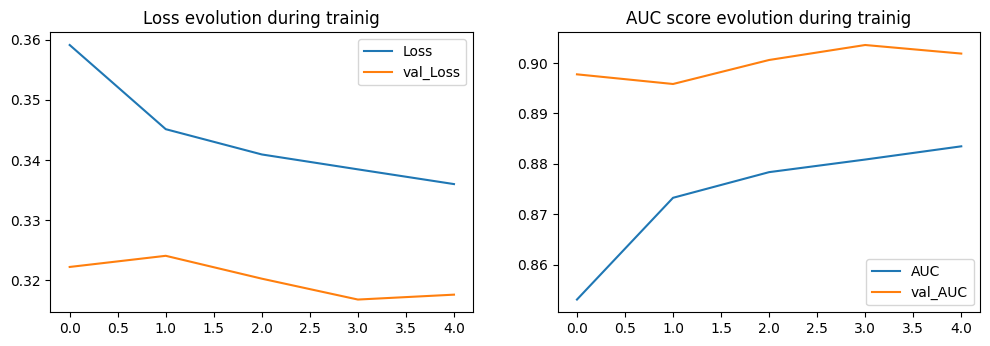

In [ ]:
plot_learning_evolution(r)

In [ ]:
model_save_path = '/content/drive/My Drive/models/loan_prediction.h5'
model.save(model_save_path);

In [ ]:
y_train_pred = model.predict(X_train)
evaluate_nn(y_train, y_train_pred.round(), train=True)

approved_count = (y_train_pred.round() == 1).sum()
rejected_count = (y_train_pred.round() == 0).sum()

print(f"Approved Loans: {approved_count}")
print(f"Rejected Loans: {rejected_count}")

# Calculate accuracy
accuracy = accuracy_score(y_train, y_train_pred.round()) * 100
print(f"Accuracy: {accuracy:.2f}%")


8192/8192 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
Train Result:
Accuracy Score: 88.78%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.89      0.89      0.89       0.89          0.89
recall        0.49      0.99      0.89       0.74          0.89
f1-score      0.63      0.93      0.89       0.78          0.87
support   51665.00 210478.00      0.89  262143.00     262143.00
_______________________________________________
Confusion Matrix: 
 [[ 25270  26395]
 [  3027 207451]]

Approved Loans: 233846
Rejected Loans: 28297
Accuracy: 88.78%


In [ ]:
y_test_pred = model.predict(X_test)
evaluate_nn(y_test, y_test_pred.round(), train=False)

# Printing the approved and rejected count
approved_count = (y_test_pred.round() == 1).sum()
rejected_count = (y_test_pred.round() == 0).sum()

print(f"Approved Loans: {approved_count}")
print(f"Rejected Loans: {rejected_count}")

4076/4076 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Test Result:
Accuracy Score: 88.78%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.89      0.89      0.89       0.89          0.89
recall        0.49      0.98      0.89       0.74          0.89
f1-score      0.63      0.93      0.89       0.78          0.87
support   25480.00 104943.00      0.89  130423.00     130423.00
_______________________________________________
Confusion Matrix: 
 [[ 12430  13050]
 [  1581 103362]]

Approved Loans: 116412
Rejected Loans: 14011


In [ ]:
loaded_model = load_model(model_save_path)
loaded_model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
dummy_data = {
    'loan_amnt': [10000],
    'term': [36],
    'int_rate': [11.44],
    'installment': [329.48],
    'annual_inc': [117000],
    'dti': [26.24],
    'earliest_cr_line': [2000],
    'open_acc': [15],
    'pub_rec': [0],
    'revol_bal': [18000],
    'revol_util': [45.0],
    'total_acc': [40],
    'mort_acc': [3],
    'pub_rec_bankruptcies': [0],
    'sub_grade_A2': [0],
    'sub_grade_A3': [0],
    'sub_grade_A4': [0],
    'sub_grade_A5': [0],
    'sub_grade_B1': [0],
    'sub_grade_B2': [0],
    'sub_grade_B3': [0],
    'sub_grade_B4': [1],
    'sub_grade_B5': [0],
    'sub_grade_C1': [0],
    'sub_grade_C2': [0],
    'sub_grade_C3': [0],
    'sub_grade_C4': [0],
    'sub_grade_C5': [0],
    'sub_grade_D1': [0],
    'sub_grade_D2': [0],
    'sub_grade_D3': [0],
    'sub_grade_D4': [0],
    'sub_grade_D5': [0],
    'sub_grade_E1': [0],
    'sub_grade_E2': [0],
    'sub_grade_E3': [0],
    'sub_grade_E4': [0],
    'sub_grade_E5': [0],
    'sub_grade_F1': [0],
    'sub_grade_F2': [0],
    'sub_grade_F3': [0],
    'sub_grade_F4': [0],
    'sub_grade_F5': [0],
    'sub_grade_G1': [0],
    'sub_grade_G2': [0],
    'sub_grade_G3': [0],
    'sub_grade_G4': [0],
    'sub_grade_G5': [0],
    'verification_status_Source Verified': [0],
    'verification_status_Verified': [1],
    'purpose_credit_card': [0],
    'purpose_debt_consolidation': [0],
    'purpose_educational': [0],
    'purpose_home_improvement': [0],
    'purpose_house': [0],
    'purpose_major_purchase': [0],
    'purpose_medical': [0],
    'purpose_moving': [0],
    'purpose_other': [0],
    'purpose_renewable_energy': [0],
    'purpose_small_business': [0],
    'purpose_vacation': [1],
    'purpose_wedding': [0],
    'initial_list_status_w': [1],
    'application_type_INDIVIDUAL': [1],
    'application_type_JOINT': [0],
    'home_ownership_MORTGAGE': [0],
    'home_ownership_NONE': [0],
    'home_ownership_OTHER': [0],
    'home_ownership_OWN': [0],
    'home_ownership_RENT': [1],
    'zip_code_05113': [0],
    'zip_code_11650': [0],
    'zip_code_22690': [1],
    'zip_code_29597': [0],
    'zip_code_30723': [0],
    'zip_code_48052': [0],
    'zip_code_70466': [0],
    'zip_code_86630': [0],
    'zip_code_93700': [0],
}

df_dummy = pd.DataFrame(dummy_data)
scaled_input = scaler.transform(df_dummy)

In [ ]:
predicted_class = loaded_model.predict(scaled_input).round()
print("Prediction:", "Approved" if predicted_class[0][0] == 1 else "Rejected")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Prediction: Approved


In [ ]:
y_test_pred = loaded_model.predict(X_test)
model_y_test_pred = (y_test_pred.round() >= 0.5).astype(int).flatten()

4076/4076 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [ ]:
approved_count = (y_test_pred.round() == 1).sum()
rejected_count = (y_test_pred.round() == 0).sum()

print(f"Approved Loans: {approved_count}")
print(f"Rejected Loans: {rejected_count}")

Approved Loans: 116412
Rejected Loans: 14011


In [ ]:
accuracy = accuracy_score(y_test, y_test_pred.round()) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 88.78%
